# ML Model to predict Housing Prices in California

In [7]:
# EDA libraries
import numpy as np # linear algebra
import pandas as pd # data preprocessing
import matplotlib.pyplot as plt # data visualization library
import seaborn as sns # data visualization library

# Sampling libraries
from sklearn.model_selection import train_test_split

# Data Transformation libraries
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

# Custom Transformation
from sklearn.base import BaseEstimator, TransformerMixin

# Data Pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Machine Learning Models and Evaluation
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [8]:
# Load Data
def get_data(dataset_name):
    return pd.read_csv(dataset_name)
housing=get_data("housing.csv")
housing.head()

# features-> longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, ocean_proximity
# target-> median_house_value

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


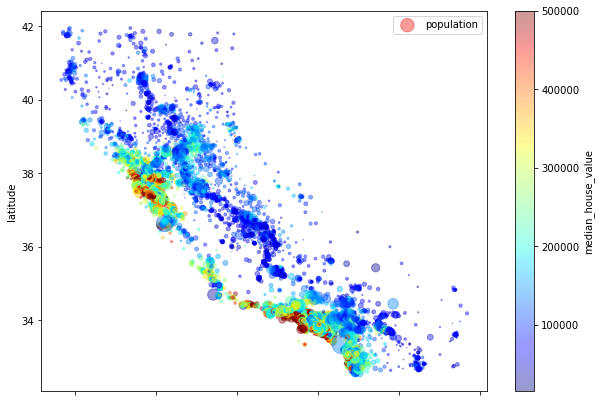

In [15]:
# EDA
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
 s=housing["population"]/100, label="population", figsize=(10,7),
 c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

    The latitude and longitude features helped us to create a plot similiar to that of the map of California.
    
    The coastal cities (San Fransisco, Los Angeles) have the more poopulation along with an increase in the house values compared to the inland areas (like Sacramento).

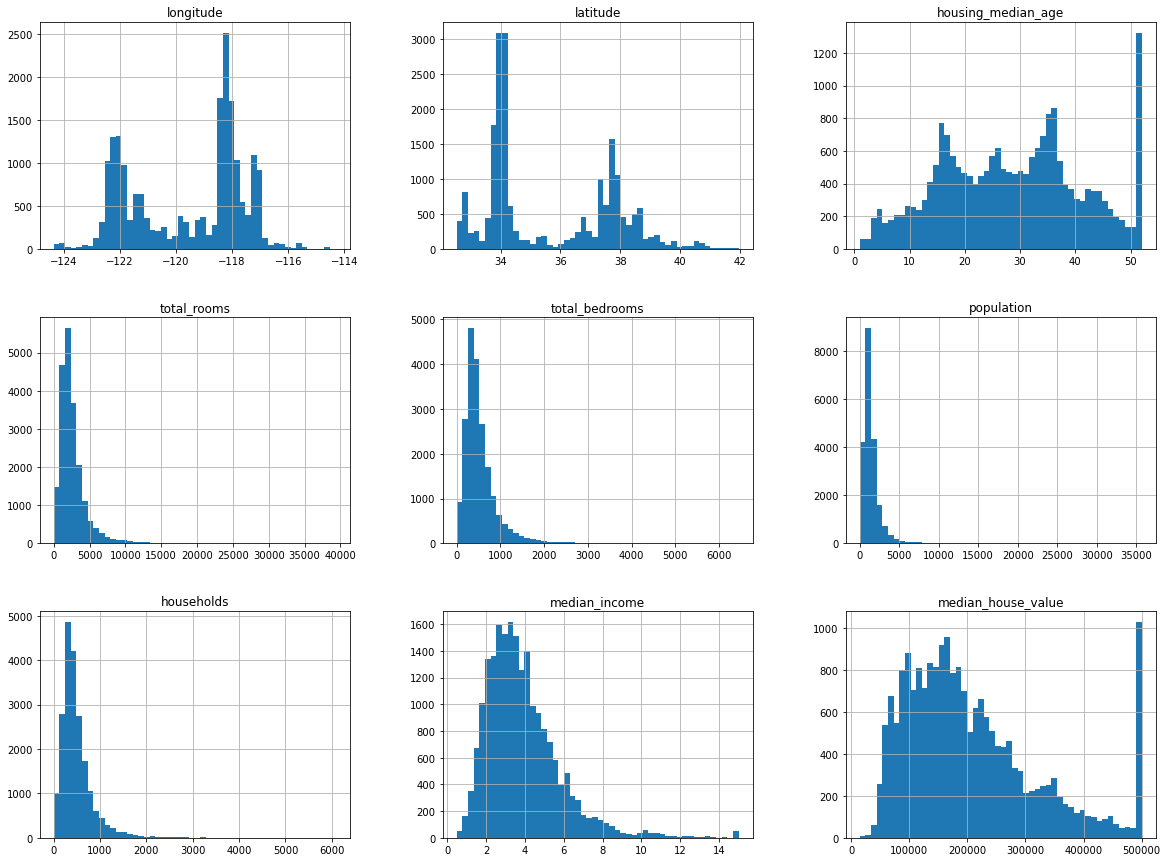

In [39]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

    The data is scattered to different ranges. Scaling must be done.

In [40]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

    Income seems to have a very noticable effect on the house values.

In [41]:
# Custom Evaluation Metric
def rmse(y,y_hat):
    return np.sqrt(mean_squared_error(y,y_hat))

In [42]:
# Custom Transformer to create add new Columns to the data to increase accuracy
room_ix, bedrooms_ix, population_ix, households_ix= 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room= True):
        self.add_bedrooms_per_room=add_bedrooms_per_room
    def fit(self,X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household=X[:,room_ix]/X[:, households_ix]
        population_per_household=X[:,population_ix]/X[:,households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room=X[:,bedrooms_ix]/X[:,room_ix]
            return np.c_[X,rooms_per_household,population_per_household,
                        bedrooms_per_room]
        else:
            return np.c_[X,rooms_per_household,population_per_household]

In [43]:
X= housing.drop("median_house_value",axis=1)
y= housing["median_house_value"]

In [44]:
X.head() # features

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,NEAR BAY


In [45]:
y.head() # target

0    452600.0
1    358500.0
2    352100.0
3    341300.0
4    342200.0
Name: median_house_value, dtype: float64

In [46]:
# Sampling
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.2, random_state=45)

In [47]:
X_train.head() # features in training data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
13240,-117.67,34.12,15.0,3162.0,495.0,1145.0,473.0,5.3525,INLAND
12586,-121.50,38.53,37.0,3642.0,684.0,1508.0,657.0,3.5231,INLAND
13123,-121.26,38.27,20.0,1314.0,229.0,712.0,219.0,4.4125,INLAND
15456,-117.28,33.18,16.0,3002.0,591.0,842.0,538.0,2.1205,NEAR OCEAN
19798,-123.12,40.54,23.0,1091.0,217.0,539.0,201.0,1.8696,INLAND


In [48]:
y_train.head() # target in training data

13240    191700.0
12586    114300.0
13123    144600.0
15456    157300.0
19798     61500.0
Name: median_house_value, dtype: float64

In [49]:
# segregating the features
num_features=["longitude","latitude","housing_median_age","total_rooms",
             "total_bedrooms","population","households","median_income"]
ordinal_features=[]
nominal_features=["ocean_proximity"]
pass_through_cols=[]
drop_cols=[]

In [50]:
# seperate pipelines for each type of features
num_pipeline=Pipeline([("imputer",SimpleImputer()),
                       ("add attribues",CombinedAttributesAdder()),
                     ("std scaler", StandardScaler())])
nominal_pipeline=Pipeline([("one hot encoding",OneHotEncoder())])

In [51]:
pipeline=ColumnTransformer([
    ("numerical pipeline",num_pipeline,num_features),
    ("nominal pipeline",nominal_pipeline,nominal_features),
    ("passing columns","passthrough",pass_through_cols),
    ("drop columns","drop",drop_cols)
])

In [52]:
# final columns in order after passing the data through pipeline
output_cols=["longitude","latitude","housing_median_age","total_rooms",
             "total_bedrooms","population","households","median_income",
             "rooms_per_household","population_per_household",
                        "bedrooms_per_room",
            "<1H OCEAN","INLAND","ISLAND","NEAR BAY","NEAR OCEAN"]

In [53]:
X_train.head(2) # training data before transforming

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
13240,-117.67,34.12,15.0,3162.0,495.0,1145.0,473.0,5.3525,INLAND
12586,-121.50,38.53,37.0,3642.0,684.0,1508.0,657.0,3.5231,INLAND


In [54]:
X_train_tr=pipeline.fit_transform(X_train)
X_train_tr=pd.DataFrame(X_train_tr,columns=output_cols)
X_train_tr.head(2) # training data after transforming

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household,bedrooms_per_room,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,0.943824,-0.704828,-1.086181,0.240758,-0.102708,-0.250026,-0.068377,0.780490,0.487808,-0.059173,-0.846552,0.0,1.0,0.0,0.0,0.0
1,-0.968715,1.359545,0.660456,0.459582,0.347450,0.077362,0.413777,-0.179806,0.043346,-0.070666,-0.390882,0.0,1.0,0.0,0.0,0.0


In [55]:
X_test.head(2) # test data before transforming

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
3046,-119.28,35.50,34.0,1923.0,379.0,1101.0,351.0,2.4044,INLAND
6803,-118.13,34.08,40.0,1931.0,449.0,1367.0,446.0,2.5750,<1H OCEAN


In [56]:
X_test_tr=pipeline.fit_transform(X_test)
X_test_tr=pd.DataFrame(X_test_tr,columns=output_cols)
X_test_tr.head(2) # test data after transforming

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household,bedrooms_per_room,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,0.163564,-0.073360,0.440681,-0.337690,-0.378690,-0.276086,-0.390347,-0.791295,0.030101,0.006279,-0.22641,0.0,1.0,0.0,0.0,0.0
1,0.736657,-0.738667,0.919063,-0.333939,-0.210769,-0.058484,-0.143658,-0.700476,-0.529451,-0.002772,0.25126,1.0,0.0,0.0,0.0,0.0


In [57]:
# ML

def generate_models_report(models, X_train_tr, y_train, X_test_tr, y_test):
    width = 116
    print("_"*width)
    title = "|{:^30}|{:^20}|{:^20}|{:^20}|{:^20}|"
    print(title.format("Model Name", "Train Error", "Test Error", "Train Accuracy", "Test Accuracy"))
    print("_"*width)
    row = "|{:^30}|{:^20.2f}|{:^20.2f}|{:^20.2f}|{:^20.2f}|"
    for model in models:
        model.fit(X_train_tr, y_train)
        y_hat_train = model.predict(X_train_tr)
        y_hat_test = model.predict(X_test_tr)
        train_error = rmse(y_train, y_hat_train)
        test_error = rmse(y_test, y_hat_test)
        train_accuracy = r2_score(y_train, y_hat_train)
        test_accuracy = r2_score(y_test, y_hat_test)
        model_name = str(model)
        print(row.format(model_name, train_error, test_error, train_accuracy*100, test_accuracy*100))
        print("-"*width)

In [58]:
models = [LinearRegression(), SGDRegressor(), SVR(), DecisionTreeRegressor(), RandomForestRegressor()]

In [59]:
generate_models_report(models, X_train_tr, y_train, X_test_tr, y_test)


____________________________________________________________________________________________________________________
|          Model Name          |    Train Error     |     Test Error     |   Train Accuracy   |   Test Accuracy    |
____________________________________________________________________________________________________________________
|      LinearRegression()      |      68049.17      |      69595.90      |       65.25        |       63.50        |
--------------------------------------------------------------------------------------------------------------------
|        SGDRegressor()        |    187383070.55    |    187315938.30    |   -263473560.64    |   -264424378.10    |
--------------------------------------------------------------------------------------------------------------------
|            SVR()             |     118285.86      |     118347.60      |       -4.99        |       -5.55        |
----------------------------------------------------------------

    Since, RandomForestRegressor() is having the best Test Accuracy, we proceed with it and find the best hyperparameters to create the best model. 

In [114]:
# Initialize the result dictionary with empty lists for each key
result={
    "models":[],
    "train_err":[],
    "test_err":[],
    "train_acc":[],
    "test_acc":[],
    "parameters":[]
}

In [152]:
# Hyper Parameter tuning
from sklearn.model_selection import GridSearchCV

In [153]:
# Define a list of hyperparameters to search over
params=[
    {
        "n_estimators": [10, 50, 100, 200, 300, 500], # The number of trees in the forest
        "max_depth": [1, 3, 6, 10], # The maximum depth of the tree
        "min_samples_split": [ 5, 10, 15, 20, 50], # The minimum number of samples required to split an internal node
        "max_features": [ 2, 3, 5, 7] # The number of features to consider when looking for the best split
    }
]

In [155]:
# GridSearchCV object to search over the hyperparameters
grid_search =GridSearchCV(RandomForestRegressor(),param_grid=params,scoring='r2')

In [156]:
grid_search.fit(X_train_tr,y_train) 

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid=[{'max_depth': [1, 3, 6, 10],
                          'max_features': [2, 3, 5, 7],
                          'min_samples_split': [5, 10, 15, 20, 50],
                          'n_estimators': [10, 50, 100, 200, 300, 500]}],
             scoring='r2')

In [157]:
best_model=grid_search.best_estimator_
print(best_model)

RandomForestRegressor(max_depth=10, max_features=7, min_samples_split=5,
                      n_estimators=500)


In [159]:
# Best hyperparamters
best_param=grid_search.best_params_
print(best_param)

{'max_depth': 10, 'max_features': 7, 'min_samples_split': 5, 'n_estimators': 500}


In [160]:
# Accuracy in percentage 
acc=grid_search.best_score_
print(acc*100) 

79.58139683772251


In [162]:
# Use the best model to make predictions on the test data
final_predictions=best_model.predict(X_test_tr)
# Root Mean Squared Error
final_rmse=np.sqrt(mean_squared_error(y_test,final_predictions))
print(final_rmse) 

53209.618644039176


In [175]:
# testing with custom input
test=pd.DataFrame([[-117.67,34.12,15.0,3162.0,495.0,1145.0,473.0,5.3525,"INLAND"]], columns=num_features + nominal_features)
test_tr=pipeline.transform(test) # tranforming data
predict=best_model.predict(test_tr) # predicting with best model
predict

array([207177.60521425])

`test` is a sample data whose original housing price is: `191700.0`

Prediction of ML Model: `207177.60521425`